# train network
- use labeled dataset to create `DataGenerator`
- set up and visualize image augmentation
- set up and visualize `TrainingGenerator`
- specify and train network

This code is modified from [here](https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb).

## inits

In [1]:
# settings
dataset = r'D:\github\fish-tracking\label\datasets\stim_dataset.h5'
# dataset = r'D:\github\locomotionAnalysis\tracking\label\training_sets\trainingset_run.h5'
model_name = r'D:\\github\\fish-tracking\\train\\models\\stim_model_1.h5'
validation_split=0


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia
from deepposekit.models import StackedDenseNet
from deepposekit.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from deepposekit.callbacks import Logger, ModelCheckpoint
import time

data_generator = DataGenerator(dataset)

%load_ext autoreload
%autoreload 2

## view sample frame

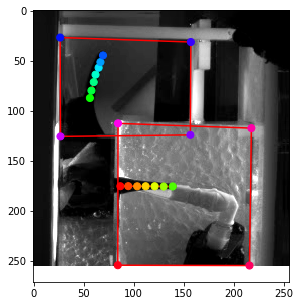

21


In [3]:
frame_num = np.random.choice(len(data_generator))
# frame_num = 1

image, keypoints = data_generator[frame_num]
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, 0]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)
plt.show()
print(jdx)

## set up image augmentation

In [4]:
# settings
rotation = (-20, 20)

augmenter, sometimes = [], []


sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=rotation,
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)


## show augmentation example

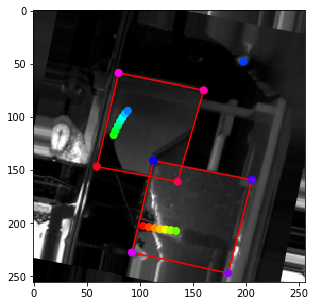

In [5]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, 0]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# create `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.

You can also look at the doc string for more explanation:


In [6]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=2,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=validation_split, 
                                    use_graph=False,  # todo: fix this for fish vids
                                    graph_scale=1)
train_generator.get_config()

D:\github\DeepPoseKit\deepposekit\io\TrainingGenerator.py:176: UserWarning: `n_validation` is 0. Increase `validation_split` to use a validation set.
  "`n_validation` is 0. Increase `validation_split` to use a validation set."


{'n_train': 20,
 'n_validation': 0,
 'validation_split': 0,
 'downsample_factor': 2,
 'output_shape': (64, 64),
 'n_output_channels': 23,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': False,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\stim_dataset.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 20,
 'image_shape': (256, 256, 1),
 'keypoints_shape': (23, 2)}

# check `TrainingGenerator` output

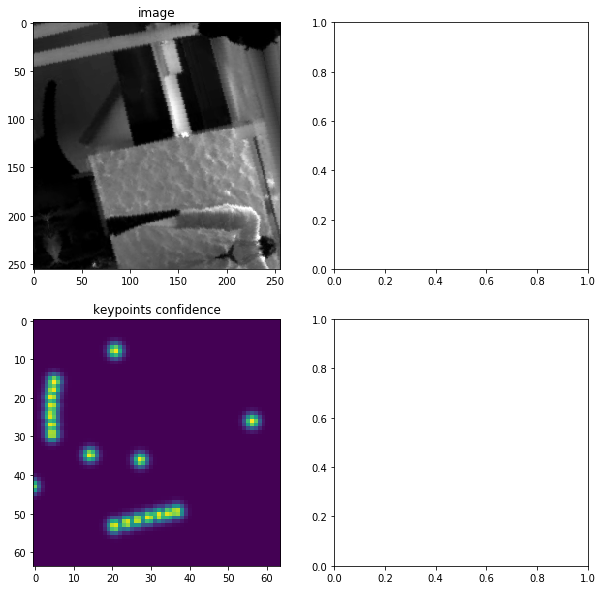

In [7]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

# ax2.set_title('posture graph')
# ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

# ax4.set_title('posture graph and keypoints confidence')
# ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# define a model
Here you can define a model to train with your data. You can use our `StackedDenseNet` model, `StackedHourglass` model, `DeepLabCut` model, or the `LEAP` model. The default settings for each model should work well for most datasets, but you can customize the model architecture. The `DeepLabCut` model has multiple pretrained (on ImageNet) backbones available for using transfer learning, including the original ResNet50 (He et al. 2015)  as well as the faster MobileNetV2 (Sandler et al. 2018; see  also Mathis et al. 2019) and DenseNet121 (Huang et al. 2017). We'll select `StackedDenseNet` and set `n_stacks=2` for 2 hourglasses, with `growth_rate=32` (32 filters per convolution). Adjust the `growth_rate` and/or `n_stacks` to change model performance (and speed). You can also set `pretrained=True` to use transfer learning with `StackedDenseNet`, which uses a DenseNet121 pretrained on ImageNet to encode the images.

You can also look at the doc strings for any of the models to get more information:

In [8]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)
model.get_config()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 7,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 20,
 'n_validation': 0,
 'validation_split': 0,
 'downsample_factor': 2,
 'output_shape': (64, 64),
 'n_output_channels': 23,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': False,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\stim_dataset.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 20,
 'image_shape': (256, 256, 1),
 'keypoints_shape': (23, 2)}

# test prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [9]:
data_size = (10000,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
y = model.predict(x[:100], batch_size=100) # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=100, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

10000/10000 [==============================] - 26s 3ms/sample
381.670014515149


# define training callbacks
Here you can define callbacks to pass to the model for use during training. You can use any callbacks available in `deepposekit.callbacks` or `tensorflow.keras.callbacks`

Remember, if you set `validation_split=0` for your `TrainingGenerator`, which will just use the training set for model fitting, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.


`Logger` evaluates the validation set (or training set if `validation_split=0` in the `TrainingGenerator`) at the end of each epoch and saves the evaluation data to a HDF5 log file (if `filepath` is set).

In [10]:
logger = Logger(validation_batch_size=5,
                filepath=model_name[:-3]+'_log.h5'
)

`ReduceLROnPlateau` automatically reduces the learning rate of the optimizer when the validation loss stops improving. This helps the model to reach a better optimum at the end of training.

In [11]:
reduce_lr = ReduceLROnPlateau(monitor="loss" if validation_split==0 else 'val_loss',
                              factor=0.2, verbose=1, patience=20)

`ModelCheckpoint` automatically saves the model when the validation loss improves at the end of each epoch. This allows you to automatically save the best performing model during training, without having to evaluate the performance manually.


In [12]:
model_checkpoint = ModelCheckpoint(
    model_name,
    monitor="loss" if validation_split==0 else 'val_loss',
    verbose=1,
    save_best_only=True,
)

`EarlyStopping` automatically stops the training session when the validation loss stops improving for a set number of epochs, which is set with the `patience` argument. This allows you to save time when training your model if there's not more improvment.

In [13]:
early_stop = EarlyStopping(
    monitor="loss" if validation_split==0 else 'val_loss',
    min_delta=0.001,
    patience=100,
    verbose=1
)

In [14]:
callbacks = [early_stop, reduce_lr, model_checkpoint]
if validation_split>0:
    callbacks.append(logger)

# train

This fits the model for a set number of epochs with small batches of data. If you have a small dataset initially you can set `batch_size` to a small value and manually set `steps_per_epoch` to some large value, e.g. 500, to increase the number of batches per epoch, otherwise this is automatically determined by the size of the dataset.

The number of `epochs` is set to `epochs=200` for demonstration purposes. **Increase the number of epochs to train the model longer, for example `epochs=1000`**. The `EarlyStopping` callback will then automatically end training if there is no improvement. See the doc string for details:

In [ ]:
model.fit(
    batch_size=5,
    validation_batch_size=5,
    callbacks=callbacks,
    #epochs=1000, # Increase the number of epochs to train the model longer
    epochs=200,
    n_workers=8,
    steps_per_epoch=20,
)

D:\github\DeepPoseKit\deepposekit\models\engine.py:145: UserWarning: 
Automatically compiling with default settings: model.compile('adam', 'mse')
Call model.compile() manually to use non-default settings.

  """\nAutomatically compiling with default settings: model.compile('adam', 'mse')\n"""
D:\github\DeepPoseKit\deepposekit\io\TrainingGenerator.py:226: UserWarning: `validation_split` is 0, so there will be no validation step. callbacks that rely on `val_loss` should be switched to `loss` or removed.
  "`validation_split` is 0, so there will be no validation step. "
D:\github\DeepPoseKit\deepposekit\models\engine.py:161: UserWarning: No validation set detected, so validation step will not be run and `val_loss` will not be available.
  "No validation set detected, so validation step will not be run and `val_loss` will not be available."


Epoch 1/200
19/20 [===========================>..] - ETA: 0s - loss: 197.5946 - output_0_loss: 68.7522 - output_1_loss: 65.4483 - output_2_loss: 63.3941
Epoch 00001: loss improved from inf to 196.40984, saving model to D:\\github\\fish-tracking\\train\\models\\stim_model_1.h5
20/20 [==============================] - 37s 2s/step - loss: 196.4098 - output_0_loss: 68.5796 - output_1_loss: 64.9892 - output_2_loss: 62.8410
Epoch 2/200
19/20 [===========================>..] - ETA: 0s - loss: 155.3876 - output_0_loss: 60.0981 - output_1_loss: 49.5348 - output_2_loss: 45.7548
Epoch 00002: loss improved from 196.40984 to 154.45006, saving model to D:\\github\\fish-tracking\\train\\models\\stim_model_1.h5
20/20 [==============================] - 3s 138ms/step - loss: 154.4501 - output_0_loss: 59.8662 - output_1_loss: 49.2052 - output_2_loss: 45.3787
Epoch 3/200
19/20 [===========================>..] - ETA: 0s - loss: 131.4992 - output_0_loss: 52.5356 - output_1_loss: 41.1299 - output_2_loss: 37.

19/20 [===========================>..] - ETA: 0s - loss: 49.9454 - output_0_loss: 22.2901 - output_1_loss: 14.6979 - output_2_loss: 12.9573
Epoch 00020: loss improved from 51.57635 to 49.52043, saving model to D:\\github\\fish-tracking\\train\\models\\stim_model_1.h5
20/20 [==============================] - 3s 134ms/step - loss: 49.5204 - output_0_loss: 22.1792 - output_1_loss: 14.5409 - output_2_loss: 12.8003
Epoch 21/200
19/20 [===========================>..] - ETA: 0s - loss: 48.5735 - output_0_loss: 21.8200 - output_1_loss: 14.3022 - output_2_loss: 12.4513
Epoch 00021: loss improved from 49.52043 to 49.29056, saving model to D:\\github\\fish-tracking\\train\\models\\stim_model_1.h5
20/20 [==============================] - 3s 142ms/step - loss: 49.2906 - output_0_loss: 21.9832 - output_1_loss: 14.5519 - output_2_loss: 12.7555
Epoch 22/200
19/20 [===========================>..] - ETA: 0s - loss: 46.2698 - output_0_loss: 21.0280 - output_1_loss: 13.6442 - output_2_loss: 11.5976
Epoch 

19/20 [===========================>..] - ETA: 0s - loss: 32.3006 - output_0_loss: 15.1585 - output_1_loss: 9.5727 - output_2_loss: 7.5694
Epoch 00040: loss did not improve from 31.12900
20/20 [==============================] - 2s 117ms/step - loss: 32.4034 - output_0_loss: 15.1524 - output_1_loss: 9.5891 - output_2_loss: 7.6620
Epoch 41/200
19/20 [===========================>..] - ETA: 0s - loss: 29.9727 - output_0_loss: 14.4124 - output_1_loss: 8.8017 - output_2_loss: 6.7586
Epoch 00041: loss improved from 31.12900 to 30.41289, saving model to D:\\github\\fish-tracking\\train\\models\\stim_model_1.h5
20/20 [==============================] - 3s 149ms/step - loss: 30.4129 - output_0_loss: 14.4876 - output_1_loss: 8.9386 - output_2_loss: 6.9866
Epoch 42/200
19/20 [===========================>..] - ETA: 0s - loss: 31.5072 - output_0_loss: 14.4549 - output_1_loss: 9.3284 - output_2_loss: 7.7240
Epoch 00042: loss did not improve from 30.41289
20/20 [==============================] - 2s 116m

Epoch 62/200
19/20 [===========================>..] - ETA: 0s - loss: 27.6540 - output_0_loss: 13.2948 - output_1_loss: 7.5550 - output_2_loss: 6.8043
Epoch 00062: loss did not improve from 22.01105
20/20 [==============================] - 2s 121ms/step - loss: 27.2235 - output_0_loss: 13.1977 - output_1_loss: 7.3824 - output_2_loss: 6.6433
Epoch 63/200
19/20 [===========================>..] - ETA: 0s - loss: 23.2122 - output_0_loss: 11.7780 - output_1_loss: 6.0411 - output_2_loss: 5.3931
Epoch 00063: loss did not improve from 22.01105
20/20 [==============================] - 2s 122ms/step - loss: 23.1882 - output_0_loss: 11.7731 - output_1_loss: 6.0344 - output_2_loss: 5.3807
Epoch 64/200
19/20 [===========================>..] - ETA: 0s - loss: 22.3310 - output_0_loss: 11.7396 - output_1_loss: 5.6875 - output_2_loss: 4.9038
Epoch 00064: loss did not improve from 22.01105
20/20 [==============================] - 2s 122ms/step - loss: 22.5010 - output_0_loss: 11.7943 - output_1_loss: 5.

Epoch 85/200
19/20 [===========================>..] - ETA: 0s - loss: 19.1853 - output_0_loss: 9.5609 - output_1_loss: 5.0068 - output_2_loss: 4.6176
Epoch 00085: loss did not improve from 17.03910
20/20 [==============================] - 2s 121ms/step - loss: 20.2857 - output_0_loss: 9.9707 - output_1_loss: 5.3593 - output_2_loss: 4.9558
Epoch 86/200
19/20 [===========================>..] - ETA: 0s - loss: 25.3837 - output_0_loss: 12.0195 - output_1_loss: 7.1317 - output_2_loss: 6.2325
Epoch 00086: loss did not improve from 17.03910
20/20 [==============================] - 2s 112ms/step - loss: 25.5150 - output_0_loss: 12.1355 - output_1_loss: 7.1345 - output_2_loss: 6.2450
Epoch 87/200
12/20 [=================>............] - ETA: 1s - loss: 20.0828 - output_0_loss: 9.8229 - output_1_loss: 5.3530 - output_2_loss: 4.9070